20210130l_m2km.fits

 - Done! time: 2.1730
 - 6000 pupil images shape: 246x329
 - Done! time: 0.3470
 - bias shape: 246x329
Data reduction...
 - Done! time: 13.5399
 - pupil shape: 226x226
Cross correlating...
 - Done! time: 106.1864
 - cross-correlation image shape: 452x452
Creating auto-corr image for pupil...
 - Done! time: 0.0540
 - auto-corr pupil image shape: 452x452
Creating temporary files...
 - Done! time: 1.5924
 - 50 turbulence layers from 0 to 50 km
Сounting the threshold...
 - Done! time: 0.2916
 - threshold: 0.0021208180114626884
Finding peaks...
 - Done! time: 0.0119
 - 5 peaks found


Text(0.5, 1.0, 'threshold')

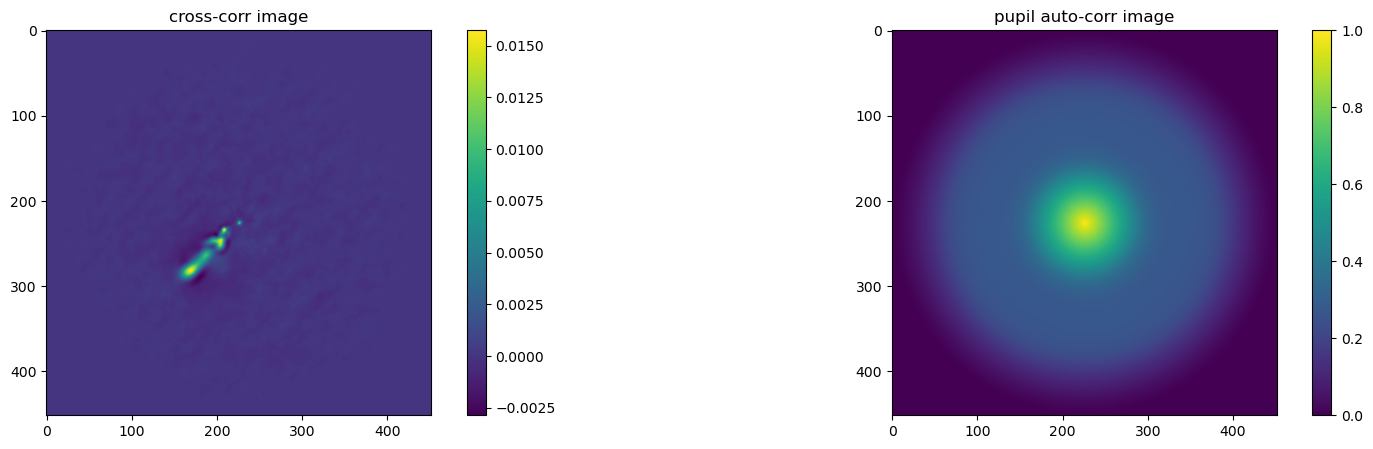

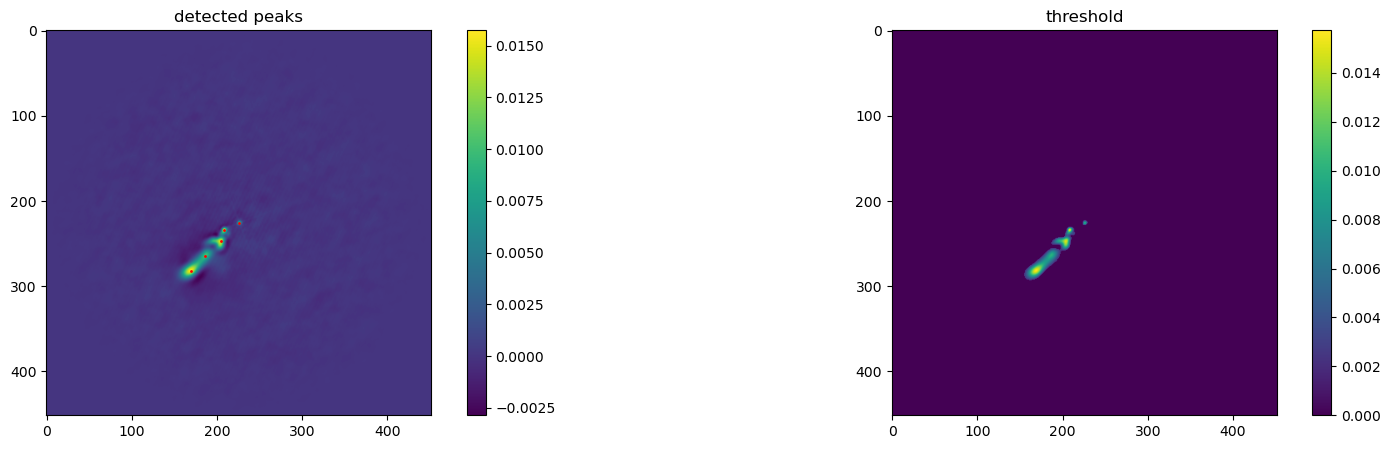

In [1]:
import matplotlib.pyplot as plt
import time

from reduction import one # получение кросс-корр.
from tempfiles import two # создание монохроматических гамм
from initialparams import best_thresh, detect_peaks

# 1. сделать по итогу два режима работы проги: авто и ручной, - авто тогда будет эта обортка
# 2. оптимизировать очистку данных и подсчет кросс-корреляции
# 3. подразумевается, что очищенное изображение зрачка квадратное и пока что оно по дефолту равно 226 на 226
# 4. https://www.sthu.org/code/codesnippets/imagepers.html - туториал к опеределению положения пиков (вар. 2)
# 5. получаемые монохроматические гаммы надо сравнить ее с резами Матевея
# 6. сделать понятную реализацию для полихроматических гамм
# 7. сдвиг изображения лучше реализовать через пиксели а не через скорости ветра, полученные параметры уже потом перевести
# в скорости ветра
# 8. можно ли заранее при создании гамм учесть домножение cjk? чтобы каждый раз не домножать внутри аппроксимации


# входные данные -------------------------------------------------------------------------
file='20210130l_m2km.fits'
file_bias='bias20210130.fits'
data_dir='D:/astro/domecam'
D=2.5 # диаметр телескопа, [метр]
latency=4 # задержка в кросс-корреляции, [кадр]
sec_per_frame=0.01 # временной промежуток между кадрами в серии, [секунда]
lambda_=500*1e-9 # длина наблюдаемой волны света, [метр]

# получение кросс-корр. ------------------------------------------------------------------------- 
cc, cjk = one(file=file, file_bias=file_bias, D=D, latency=latency, sec_per_frame=sec_per_frame, data_dir=data_dir)
# cc - картина кросс-корреляции
# cjk - картина автокорреляции зрачка 

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.colorbar(ax.imshow(cc), ax=ax)
fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax.set_title('cross-corr image')
ax2.set_title('pupil auto-corr image')

# создание монохроматических гамм -------------------------------------------------------------------------
gammas = two(lambda_, cjk=cjk, D=D, sec_per_frame=sec_per_frame, latency=latency)

# подгонка начальных параметров для аппроксимации -------------------------------------------------------------------------
thresh = best_thresh(cc, acc=5) # порог макисмального значения в аппроксимации
y, x = detect_peaks(cc * (cc>thresh), size_of_neighborhood=7) # координаты целевых пиков

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax.scatter(x, y, c='red', s=1)
fig.colorbar(ax.imshow(cc), ax=ax)
fig.colorbar(ax2.imshow(cc * (cc>thresh)), ax=ax2)
ax.set_title('detected peaks')
ax2.set_title('threshold')
# аппроксимация 

In [ ]:
from clean import curvef

curvef(file=f'data/20210130j_m2km_corr_4_blur.gz', #c,d,e,g,h,i,j,l,m
       file2=None,
       mode='blur', 
       D=2.5, 
       latency=4, 
       sec_per_frame=0.01, 
       dist0=2, # нужно для отрисовки профиля, отнимается от file
       dist02=0,
       gain=1, 
       thresh_manual=0, 
       thresh_manual2=0,
       niter=50, 
       window=15,
       run_clean='yes',
       checkpointf='no', 
       step=None,
       seeing_lambda=500*pow(10, -9),
       data_dir='D:/astro/domecam')

# сделать сортировку в err по индексам из обычных дат. и после этого уже включить сброс индексов, чтобы они по порядку 
# отображались

#1. создать библиотеку монохроматических гамм на 500 нм
# пока что тестировать на монохроматических гаммах (потому что так проще библиотеку гамм использовать)
# 2. cjk ведь можно поделить на gamma_jk, чтобы в аппроксимации его не учитывать, ведь так? (как у матвея)